In [44]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
#globals
TOTAL_FEATURES = 8
BACK_CANDLES = 10
FUTURE_DAYS = 1

def create_stock_dictionary():
    dictionary = {}
    current_directory = os.getcwd()
    folder_name = 'S&P500'
    folder_path = os.path.join(current_directory, folder_name)

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            name = file_name.split("_")[0]
            file_path = os.path.join(folder_path, file_name)
            dictionary[name] = pd.read_csv(file_path)
            
    return dictionary


In [87]:
import random
stock_data = create_stock_dictionary()
random_keys = ['AAPL', 'MSFT', 'LOW', 'VZ', 'NVDA']
random_keys


['AAPL', 'MSFT', 'LOW', 'VZ', 'NVDA']

In [102]:
from sklearn.model_selection import train_test_split
n_days = BACK_CANDLES
m_days = FUTURE_DAYS
random_stock_data = {}
random_stock_data_testing = {}
#split data for training
for i in random_keys:
    stock_data[i]["TargetNextClose"] = stock_data[i]["Adj Close"].shift(-1)
    stock_data[i].rename(columns = {'Datetime':'Date'}, inplace = True)
    scaler = MinMaxScaler()
    for k in range(1, stock_data[i].shape[1]):
        column_data = stock_data[i].iloc[:, k].values.reshape(-1, 1)
        stock_data[i].iloc[:, k] = scaler.fit_transform(column_data)
    
    random_stock_data[i], random_stock_data_testing[i] = train_test_split(stock_data[i], test_size=0.2, shuffle=False)
random_stock_data['MSFT']

,Date,Open,High,Low,Adj Close,Volume,TargetNextClose
0,2022-04-07 09:30:00-04:00,0.394586,0.422921,0.401450,0.424764,0.256144,0.418512
1,2022-04-07 10:30:00-04:00,0.420142,0.422335,0.418811,0.418512,0.128951,0.414587
2,2022-04-07 11:30:00-04:00,0.413863,0.413228,0.413456,0.414587,0.099239,0.418124
3,2022-04-07 12:30:00-04:00,0.409832,0.414424,0.412585,0.418124,0.084091,0.417882
4,2022-04-07 13:30:00-04:00,0.413350,0.416427,0.418879,0.417882,0.094179,0.428156
...,...,...,...,...,...,...,...
2673,2023-10-17 09:30:00-04:00,0.555499,0.567606,0.551825,0.566756,0.158124,0.568799
2674,2023-10-17 10:30:00-04:00,0.563439,0.568387,0.568286,0.568799,0.067922,0.575382
2675,2023-10-17 11:30:00-04:00,0.565418,0.571463,0.571918,0.575382,0.051537,0.571699
2676,2023-10-17 12:30:00-04:00,0.572015,0.573417,0.575016,0.571699,0.042814,0.565568


In [103]:
stacked_stock_data = pd.concat((random_stock_data.values()), ignore_index=True, axis=0)
stacked_stock_data.dropna()

,Date,Open,High,Low,Adj Close,Volume,TargetNextClose
0,2022-04-07 09:30:00-04:00,0.627604,0.645420,0.629669,0.640124,0.297035,0.623686
1,2022-04-07 10:30:00-04:00,0.640066,0.635378,0.624160,0.623686,0.158285,0.624225
2,2022-04-07 11:30:00-04:00,0.623562,0.623929,0.621271,0.624225,0.127203,0.628133
3,2022-04-07 12:30:00-04:00,0.623966,0.621656,0.613814,0.628133,0.145370,0.634735
4,2022-04-07 13:30:00-04:00,0.628075,0.633570,0.626579,0.634735,0.118171,0.647834
...,...,...,...,...,...,...,...
13385,2023-10-17 09:30:00-04:00,0.420344,0.418976,0.407565,0.416104,0.488579,0.421708
13386,2023-10-17 10:30:00-04:00,0.416927,0.419844,0.423519,0.421708,0.198357,0.428777
13387,2023-10-17 11:30:00-04:00,0.422448,0.426311,0.428518,0.428777,0.142803,0.419716
13388,2023-10-17 12:30:00-04:00,0.429512,0.426095,0.427295,0.419716,0.103629,0.419062


In [104]:
xs, ys = [], []
#for actuallly training data
for i in range(len(stacked_stock_data) - n_days): 

    v = stacked_stock_data.iloc[i:(i + n_days), :]

    if v['Date'].iloc[-1] <= v['Date'].iloc[0]: 
        continue

    xs.append(v.iloc[:, 1:-1].to_numpy())
    ys.append(stacked_stock_data.iloc[i + n_days, len(stacked_stock_data.columns) - 1])
xs = np.array(xs)
ys = np.array(ys)

ys

array([0.61142695, 0.62206965, 0.6139855 , ..., 0.41971577, 0.41906191,
       0.41846425])

In [118]:
X_test = []
Y_test = []

for key, df in random_stock_data_testing.items():
    if(key == 'AAPL'):
        continue
    if len(df) >= n_days + m_days:
        for i in range(len(df) - n_days - m_days + 1):
            X_test.append(df.iloc[i:i+n_days, 1:-1].to_numpy())

        for i in range(len(df) - n_days - m_days + 1):
            Y_test.append(df.iloc[i+n_days:i+n_days+m_days, -1].to_numpy())
    break

X_test = np.array(X_test)
Y_test = np.array(Y_test)

Y_test


array([[0.58541317],
       [0.59055007],
       [0.58032464],
       [0.56995399],
       [0.56704628],
       [0.5528955 ],
       [0.54349413],
       [0.54577167],
       [0.55238675],
       [0.54698321],
       [0.5472256 ],
       [0.54486302],
       [0.54790399],
       [0.55693   ],
       [0.56346019],
       [0.56874246],
       [0.56808818],
       [0.5604071 ],
       [0.55691787],
       [0.56520517],
       [0.56142474],
       [0.55517319],
       [0.55696638],
       [0.56350855],
       [0.56806393],
       [0.5648171 ],
       [0.61121876],
       [0.60285973],
       [0.60760841],
       [0.60300467],
       [0.60843232],
       [0.61332681],
       [0.61269694],
       [0.57782896],
       [0.56452634],
       [0.55410703],
       [0.55052094],
       [0.56011634],
       [0.55851703],
       [0.55052094],
       [0.58085779],
       [0.58962973],
       [0.57707781],
       [0.56874246],
       [0.55934094],
       [0.55856554],
       [0.56011634],
       [0.586

In [120]:
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from keras import Sequential
from keras import optimizers
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense, GRU, LSTM

model = Sequential()
model.add(GRU(11, input_shape=(xs.shape[1], xs.shape[2])))
model.add(Dense(11, activation="relu"))
model.add(Dense(1))
model.compile(loss='mae', optimizer=Adam(1 / 1000))
model.fit(xs, ys, epochs=10, batch_size=8, validation_split=0.2)




Epoch 1/10


c:\Users\Rober\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1335/1335 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 0.0685 - val_loss: 0.0083
Epoch 2/10
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.0150 - val_loss: 0.0048
Epoch 3/10
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.0147 - val_loss: 0.0070
Epoch 4/10
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.0145 - val_loss: 0.0058
Epoch 5/10
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.0141 - val_loss: 0.0056
Epoch 6/10
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0140 - val_loss: 0.0050
Epoch 7/10
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 0.0143 - val_loss: 0.0047
Epoch 8/10
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0139 - val_loss: 0.0065
Epoch 9/10
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0136 - val_loss: 0.0045
Epoch 10/10
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0138 - val_loss: 0.0054


14/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


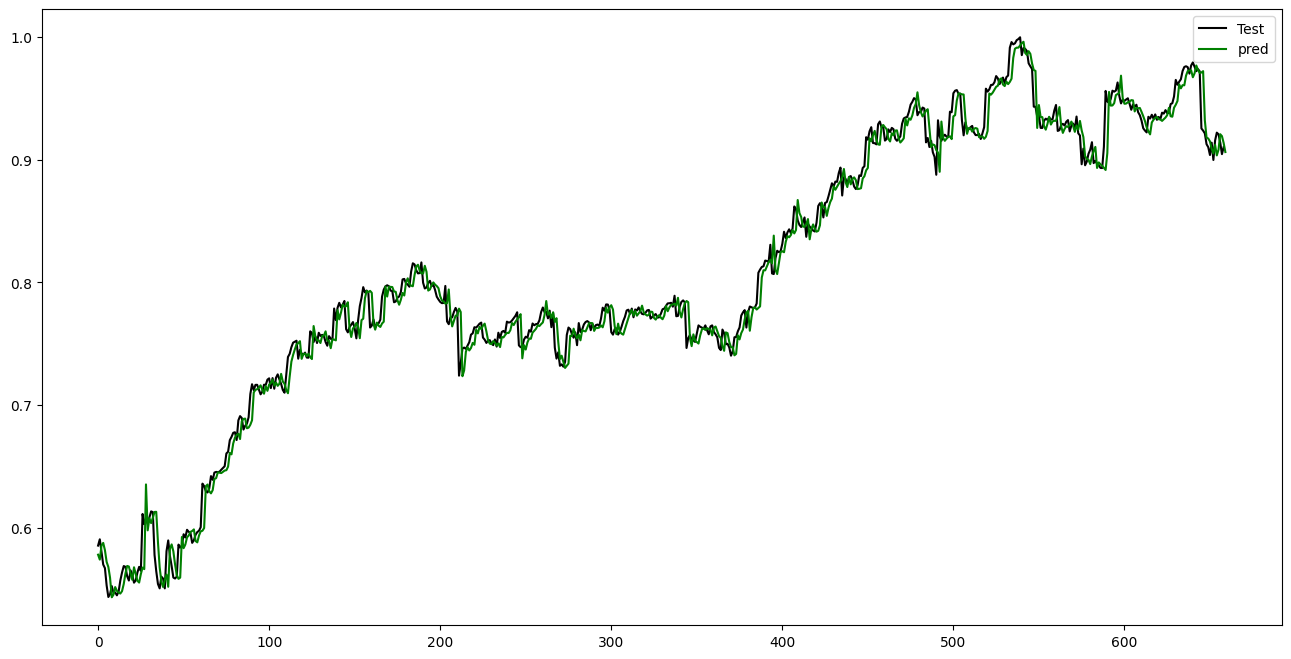

In [121]:
y_pred = model.predict(X_test)

plt.figure(figsize=(16,8))
plt.plot(Y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()
